In [ ]:
# Importing the standard ML libraries...
%load_ext autoreload
%autoreload 2

import pandas as pd                     # to process our data
import matplotlib.pyplot as plt         # graphing
import numpy as np                      # matrices

import torch
import torchvision                      # for MNIST dataset/working with images
import os
from PIL import Image
import cv2
from google.colab.patches import cv2_imshow

# take advantage of GPU if available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [ ]:
!gdown --id 1SYoD7dCZT80GtXgNc6A6JohaLyIP1gpv

Downloading...
From: https://drive.google.com/uc?id=1SYoD7dCZT80GtXgNc6A6JohaLyIP1gpv
To: /content/training-renders-cropped.zip
100% 277M/277M [00:01<00:00, 176MB/s]


In [ ]:
!unzip -q training-renders-cropped.zip

In [ ]:
FOLDER = "content/training_renders_cropped/"

In [ ]:
piece_map = {"wp": 0, "wb": 1, "wn": 2, "wr": 3, "wq": 4, "wk": 5, "bp": 6, "bb": 7, "bn": 8, "br": 9, "bq": 10, "bk": 11, "blank": 12}
data = []

for f in os.listdir(FOLDER):
  if str(f) != "all":
    for file in os.listdir(FOLDER + f):
      img = cv2.imread(FOLDER + f + "/" + file, cv2.IMREAD_GRAYSCALE)
      data.append((piece_map[f], img))

data = np.array(data)
print(len(data))

61120


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  # Remove the CWD from sys.path while we load stuff.


In [ ]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(data, test_size=0.2)
print(len(train), len(test))

48896 12224


In [ ]:
class ImageDataset(torch.utils.data.Dataset):
    def __init__(self, data):
        # initialize your data from file and store it in memory
        self.image_data = []
        self.label_data = []
        self.image_shape = (1, 92, 46)
        self.length = len(data)
        for i in range(len(data)):
            self.label_data.append(data[i][0])
            self.image_data.append(data[i][1])

        self.image_data = np.expand_dims(np.asarray(self.image_data), 1)
        self.images = torch.tensor(self.image_data, dtype=torch.float32)
        self.labels = torch.tensor(self.label_data, dtype=torch.float32)

    def __len__(self):
        return self.length # this should return the number of elements in your dataset
    
    def __getitem__(self, idx):
        return self.image_data[idx], self.label_data[idx]
        #return image, label # this should return a tuple of (image, label)
                              # where `image` is the image as a tensor
                              # and `label` is the ground truth label as a float

torch.Size([48896, 1, 92, 46])


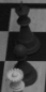

In [ ]:
train_dataset = ImageDataset(train)
test_dataset = ImageDataset(test)
batch_size = 128
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
print(trainloader.dataset.images.shape)
cv2_imshow(data[0][1])

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
class ConvolutionalNeuralNet(nn.Module):
    def __init__(self):
      super(ConvolutionalNeuralNet, self).__init__()
      self.conv1 = nn.Conv2d(1, 6, 5) #1 for B and W
      self.pool = nn.MaxPool2d(2, 2)
      self.conv2 = nn.Conv2d(6, 16, 5)
      self.fc1 = nn.Linear(2560, 120)
      self.fc2 = nn.Linear(120, 84)
      self.fc3 = nn.Linear(84, 13) #13 classes

    def forward(self, x):
      x = self.pool(F.relu(self.conv1(x)))
      x = self.pool(F.relu(self.conv2(x)))
      x = x.view(x.size(0), -1)#x = x.view(-1, 16*5*5)
      x = F.relu(self.fc1(x))
      x = F.relu(self.fc2(x))
      x = self.fc3(x)
      return x

In [ ]:
cnn_model = ConvolutionalNeuralNet().to(device=device, dtype=torch.float) # Don't forget to add .to(device=device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(cnn_model.parameters(), lr = 0.0005, weight_decay=0.1)

val_losses = []
train_losses = []

for epoch in range(100):
    epoch_loss = 0
    cnn_model.train()
    for batch_idx, (images, labels) in enumerate(trainloader):
        images = images.cuda()
        labels = labels.cuda() # Put the labels on GPU as well
        images = images.float()

        optimizer.zero_grad()                 # resets the information from last time
        pred_y = cnn_model(images)            # calculates the predictions
        loss = criterion(pred_y, labels)      # calculates the loss
        loss.backward()                       # gradient descent, part 1
        optimizer.step()                      # gradient descent, part 2
        epoch_loss += loss.item()
    epoch_loss /= len(train_dataset)
    train_losses.append(epoch_loss)
    
    cnn_model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch_idx, (images, labels) in enumerate(testloader):   
            images = images.float()    
            output = cnn_model(images.cuda())
            labels = labels.cuda()
            loss = criterion(output, labels)
            val_loss += loss.item()
        val_loss /= len(test_dataset)
        val_losses.append(val_loss)
        
    print(f"Epoch {epoch}: {epoch_loss} Val: {val_loss}")

Epoch 0: 0.0030378766284148693 Val: 0.0017271159821389858
Epoch 1: 0.001500583878085651 Val: 0.0014071397176158677
Epoch 2: 0.0011842836312284078 Val: 0.0011574536356562992
Epoch 3: 0.0009640846918007915 Val: 0.0010001666329469512
Epoch 4: 0.0008457886474222281 Val: 0.000983327637467392
Epoch 5: 0.0007495552839142032 Val: 0.0009156781759512908
Epoch 6: 0.0006512971461219689 Val: 0.0009262643197395337
Epoch 7: 0.000607535698486453 Val: 0.0008163022329050716
Epoch 8: 0.0005427265263355156 Val: 0.0008014093497700999
Epoch 9: 0.00048292201610906194 Val: 0.0009470004463417173


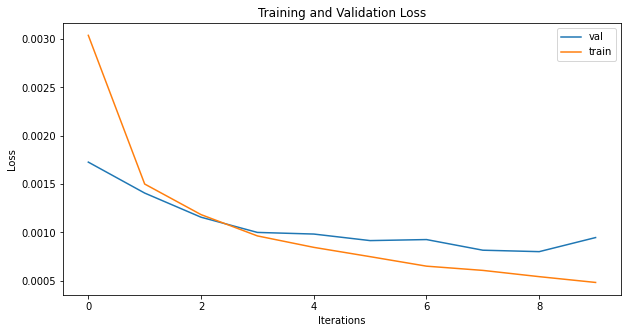

<Figure size 432x288 with 0 Axes>

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Training and Validation Loss")
plt.plot(val_losses,label="val")
plt.plot(train_losses,label="train")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()
plt.savefig("train_val_loss")

In [ ]:
stateDict = cnn_model.state_dict()
torch.save(stateDict, "/content/model_weights.pt")
torch.save(cnn_model, "/content/full_model.pt")

In [ ]:
!gdown --id 1xDiRz0AkEOACKIwCI9U0F-7G4KbxeO08

Downloading...
From: https://drive.google.com/uc?id=1xDiRz0AkEOACKIwCI9U0F-7G4KbxeO08
To: /content/46x92_OrigOnly_2.pt
100% 1.29M/1.29M [00:00<00:00, 82.3MB/s]


In [ ]:
cnn_model = torch.load("46x92_OrigOnly_2.pt")

Number predicted correctly by category: 
{0: 729, 1: 102, 2: 112, 3: 206, 4: 96, 5: 132, 6: 789, 7: 56, 8: 110, 9: 214, 10: 75, 11: 102, 12: 6699}
Number actually occurring by category: 
{0: 758, 1: 128, 2: 115, 3: 220, 4: 108, 5: 141, 6: 809, 7: 117, 8: 117, 9: 225, 10: 97, 11: 165, 12: 6728}
Ratio correct by category: 
[0.9617414248021108, 0.796875, 0.9739130434782609, 0.9363636363636364, 0.8888888888888888, 0.9361702127659575, 0.9752781211372065, 0.47863247863247865, 0.9401709401709402, 0.9511111111111111, 0.7731958762886598, 0.6181818181818182, 0.9956896551724138]
Overall Percent Correct: 96.85444078947368%
Percent Correct Without Including Empty Squares: 90.76666666666667%
Precision:  0.9224254742547425
Accuracy:  0.9224254742547425
Recall:  0.9224254742547425


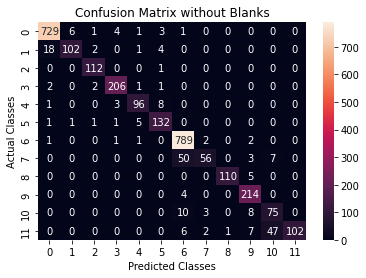

In [ ]:
from sklearn.metrics import confusion_matrix, recall_score, accuracy_score, precision_score
import seaborn as sns

count = 0
pred_dict = {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0}
true_dict = {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0}

guess_arr = []
actual_arr = []

dataiter = iter(testloader)
images, labels = dataiter.next()


images = images.cuda()
labels = labels.cuda()
images = images.float()
outputs = cnn_model(images)
_, predicted = torch.max(outputs, 1)

for i in range(len(images)):
  p = int(predicted[i].cpu().numpy())
  l = int(labels[i].cpu().numpy())
  if p != 12 and l != 12:
    guess_arr.append(p)
    actual_arr.append(l)
  if p == l:
    pred_dict[p] += 1
    count += 1
  true_dict[l] += 1

n = 75

for k in range(n):
    images, labels = dataiter.next()

    images = images.cuda()
    labels = labels.cuda()
    images = images.float()
    outputs = cnn_model(images)
    _, predicted = torch.max(outputs, 1)

    for i in range(len(images)):
      p = int(predicted[i].cpu().numpy())
      l = int(labels[i].cpu().numpy())
      if p != 12 and l != 12:
        guess_arr.append(p)
        actual_arr.append(l)
      if p == l:
        pred_dict[p] += 1
        count += 1
      true_dict[l] += 1

print("Number predicted correctly by category: ")
print(pred_dict)
print("Number actually occurring by category: ")
print(true_dict)
pred_arr = [pred_dict[i] for i in range(13)]
true_arr = [true_dict[i] for i in range(13)]
arr = [pred_dict[i] / true_dict[i] for i in range(13)]
print("Ratio correct by category: ")
print(arr)

true_sum = sum(true_arr)
pred_sum = sum(pred_arr)
print("Overall Percent Correct: " + str(pred_sum/true_sum * 100) + "%")

true_sum_no_blank = sum(true_arr[:-1])
pred_sum_no_blank = sum(pred_arr[:-1])
print("Percent Correct Without Including Empty Squares: " + str(pred_sum_no_blank / true_sum_no_blank * 100) + "%")
cm = confusion_matrix(actual_arr, guess_arr)
ax = sns.heatmap(cm, annot=True, fmt='g')
ax.set_title('Confusion Matrix without Blanks');
ax.set_xlabel('Predicted Classes')
ax.set_ylabel('Actual Classes');

print("Precision: ", precision_score(actual_arr, guess_arr, average='micro'))
print("Accuracy: ", accuracy_score(actual_arr, guess_arr))
print("Recall: ", recall_score(actual_arr, guess_arr, average='micro'))